In [20]:
#google colab installs:
#!pip install dgl
#!DGLBACKEND=pytorch
#!export $DGLBACKEND
#!pip install forgi
#!tar -xf data.tar.xz

import dgl
import numpy as np
import torch as th
import forgi.threedee.model.coarse_grain as ftmc
import matplotlib.pyplot as plt
from dgl_classifier.data import CGDataset

print(th.__version__)
print(th.cuda.is_available())

device = th.device("cuda" if th.cuda.is_available() else "cpu")
print("Using:", device)




ImportError: cannot import name 'CGDataset' from 'dgl_classifier.data' (/home/milan/MS_Arbeit/3d_classifier/dgl_classifier/data.py)

TODO:
*  include checkpoints, that save model parameters for later testing **DONE**
*  implement gpu usage **DONE**
*  implement checkpoints 
*  use dgl.save_graph() to store a graph, so the structure can be used for several steps?
*  use forgi.threedee.model.coarse_grain.CoarseGrainRNA.rotate() to rotate cg RNAs and see if the classification changes
*  future --> find where ernwin writes/stores output of structure for each n steps
*  finetune the model
*  include logger (maybe wandb?)

In [17]:
#Model
import dgl.nn as dglnn
import torch.nn.functional as F

#Coarse Grain RNA Classifier Model
class CG_Classifier(th.nn.Module):
    def __init__(self, num_features):
        self.c = 0
        super(CG_Classifier, self).__init__()
        
        self.conv1 = dglnn.TAGConv(6, 200, k=2, activation=F.elu)
        self.conv2 = dglnn.TAGConv(200, 150, k=2, activation=F.elu)
        self.conv3 = dglnn.TAGConv(150, 100, k=2, activation=F.elu)
        self.conv4 = dglnn.TAGConv(100, 50, k=2, activation=F.elu)
        self.conv5 = dglnn.TAGConv(50, 25, k=2, activation=F.elu)
        
        self.sage_conv1 = dglnn.SAGEConv(25*num_features, 100, 'pool') # sageconv 'pool' 'gcn'
        self.sage_conv2 = dglnn.SAGEConv(100, 60, 'pool') 
        self.sage_conv3 = dglnn.SAGEConv(60, 40, 'pool')  
        self.sage_conv4 = dglnn.SAGEConv(40, 30, 'pool') 
        self.sage_conv5 = dglnn.SAGEConv(30, 20, 'pool')
        
        self.readout = dglnn.AvgPooling() #SumPooling() #dglnn.Set2Set(20, 3, 3) # AvgPooling worked best
        
        self.classify = th.nn.Sequential(
            th.nn.Linear(20, 512),
            th.nn.ELU(),
            #th.nn.Linear(512, 512),
            #th.nn.ELU(),
            th.nn.Linear(512, 512),
            th.nn.ELU(),
            th.nn.Linear(512, 512),
            th.nn.ELU(),
            th.nn.Linear(512, 1)
        )

        
    def forward(self, g):
        #treat node features separately
        nt = g.ndata["type"]
        nc = g.ndata["coord"]
        nw = g.ndata["twist"]
        
        nt = self.conv1(g, nt)
        nt = self.conv2(g, nt)
        nt = self.conv3(g, nt)
        nt = self.conv4(g, nt)
        nt = self.conv5(g, nt)

        nc = self.conv1(g, nc)
        nc = self.conv2(g, nc)
        nc = self.conv3(g, nc)
        nc = self.conv4(g, nc)
        nc = self.conv5(g, nc)
        
        nw = self.conv1(g, nw)
        nw = self.conv2(g, nw)
        nw = self.conv3(g, nw)
        nw = self.conv4(g, nw)
        nw = self.conv5(g, nw)
        
        #combine the features
        g.ndata["combi"] = th.cat((nt, nc, nw), 1)

        combi = g.ndata["combi"]
        combi = self.sage_conv1(g, combi)
        combi = self.sage_conv2(g, combi)
        combi = self.sage_conv3(g, combi)
        combi = self.sage_conv4(g, combi)
        combi = self.sage_conv5(g, combi)
        
        tcw = self.readout(g, combi)
        
        #mean in dim 0 is used to get rid of list in list tensor.. i.e. shape [x, 1] becomes [x]
        tcw_mean = tcw.mean(dim=0) #dgl.mean_nodes(g, combi)
        
        return self.classify(tcw_mean)

In [9]:
#Training Set
import dgl.dataloading as dtl

training_dir = "./data/train_set"
rmsd_list = "./data/truncated_train_rmsd.txt" #"./data/train_rmsd_list.txt"

training_dataset = CGDataset(training_dir, rmsd_list, device)


In [8]:
#Validation Set
val_dir = "./data/val_set"
val_rmsd = "./data/val_rmsd_list.txt"

val_dataset = CGDataset(val_dir, val_rmsd, device)

val_dataloader = dtl.pytorch.GraphDataLoader(val_dataset)

Epoch 0: Training loss 61.7183, Validation loss 22.6890, learning rate: 0.00100
Epoch 5: Training loss 3.8977, Validation loss 19.1963, learning rate: 0.00099
Epoch 10: Training loss 2.9373, Validation loss 21.2686, learning rate: 0.00097
Epoch 15: Training loss 2.5491, Validation loss 17.7490, learning rate: 0.00094
Epoch 20: Training loss 2.3426, Validation loss 18.7435, learning rate: 0.00090
Epoch 25: Training loss 1.7185, Validation loss 20.5929, learning rate: 0.00084
Epoch 30: Training loss 1.3867, Validation loss 19.2315, learning rate: 0.00078
Epoch 35: Training loss 1.5210, Validation loss 17.6329, learning rate: 0.00071
Epoch 40: Training loss 1.0142, Validation loss 20.5810, learning rate: 0.00064
Epoch 45: Training loss 0.8658, Validation loss 18.1742, learning rate: 0.00056
Epoch 50: Training loss 0.5944, Validation loss 17.8821, learning rate: 0.00048
Epoch 55: Training loss 0.5673, Validation loss 18.6930, learning rate: 0.00041
Epoch 60: Training loss 0.5412, Validatio

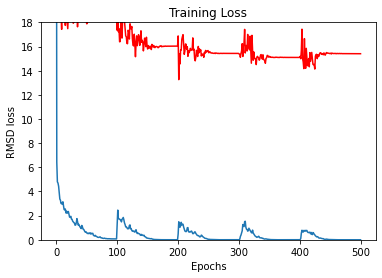

In [10]:
#Training
import time
start = time.perf_counter()
model = CG_Classifier(
    num_features=3 #len(graph.ndata)
)

model.to(device)

epochs = 500

b_size = 64
train_dataloader = dtl.pytorch.GraphDataLoader(training_dataset, batch_size=b_size, shuffle=True)#, use_ddp=True)


opt = th.optim.Adam(model.parameters(), lr=1e-3) #SGD(model.parameters(), lr=1e-2, momentum=0.9) #
scheduler = th.optim.lr_scheduler.CosineAnnealingWarmRestarts(opt, T_0=100) #OneCycleLR(opt, max_lr=1e-3, steps_per_epoch=len(train_dataloader), epochs=epochs)  #
model.train()


#training setup
val_losses = []
epoch_losses = []
learning_rates = []
for epoch in range(epochs):
    epoch_loss = 0
    learning_rates.append(scheduler.get_last_lr()[0])
    for iter, (batched_graph, batch_labels) in enumerate(train_dataloader):
        batched_graph = batched_graph.to(device)
        batch_labels = batch_labels.to(device)
        l = []
        for graph in dgl.unbatch(batched_graph):
            pred = model(graph)
            l.append(pred)
        
        logits = th.cat(l)
        loss = F.smooth_l1_loss(logits, batch_labels, reduction='mean') # smooth_l1_loss

        opt.zero_grad()
        loss.backward()
        opt.step()
        epoch_loss += loss.detach().item()

    #apply lr changes according to scheme
    scheduler.step()

    epoch_loss /= (iter + 1)
    epoch_losses.append(epoch_loss)

    #val setup
    val_loss = 0
    for i, (v_graph, v_label) in enumerate(val_dataloader):
        val_pred = model(v_graph)
        v_loss = F.smooth_l1_loss(val_pred, v_label, reduction='mean')  # smooth_l1_loss
        val_loss += v_loss.detach().item()

    val_loss /= (i + 1)
    
    val_losses.append(val_loss)
    
    

    #if epoch >= 20:
    th.save(model.state_dict(), "dgl_model_data/model_epoch" + str(epoch) + ".pth")
    
    if epoch % 5 == 0:
        print("Epoch {}: Training loss {:.4f}, Validation loss {:.4f}, learning rate: {:.5f}".format(epoch, epoch_loss, val_loss, scheduler.get_last_lr()[0]))
        
end = time.perf_counter()

print("Training took {:.2f} hours".format((end - start)/60/60))
print("Minimum Training Loss {:.4f} in epoch {}".format(min(epoch_losses), epoch_losses.index(min(epoch_losses))))
print("Minimum Validation Loss {:.4f} in epoch {}".format(min(val_losses), val_losses.index(min(val_losses))))

#plot the training run
plt.plot(epoch_losses)
plt.plot(val_losses, 'r')
plt.title("Training Loss")
plt.xlabel("Epochs")
plt.ylabel("RMSD loss")
plt.ylim(ymax=18, ymin=0)
plt.draw()

In [19]:
#store training run data

file = "loss_data_2022-02-15.txt"

with open("data/" + file, "w") as fh:
    fh.write(str(epoch_losses) + "\n")
    fh.write(str(val_losses) + "\n")
    fh.write(str(learning_rates))

In [9]:
#get training run data

file = "loss_data_2022-02-15.txt"

file_lines = []
with open("data/" + file, "r") as fh:
    for line in fh.readlines():
        file_lines.append(line.rstrip("]\n").lstrip("[").split(","))

epoch_losses = [float(a) for a in file_lines[0]]
val_losses = [float(b) for b in file_lines[1]]
learning_rates = [float(c) for c in file_lines[2]]

print("Minimum Training Loss {:.4f} in epoch {}".format(min(epoch_losses), epoch_losses.index(min(epoch_losses))))
print("Minimum Validation Loss {:.4f} in epoch {}".format(min(val_losses), val_losses.index(min(val_losses))))


Minimum Training Loss 0.0002 in epoch 999
Minimum Validation Loss 13.1550 in epoch 607


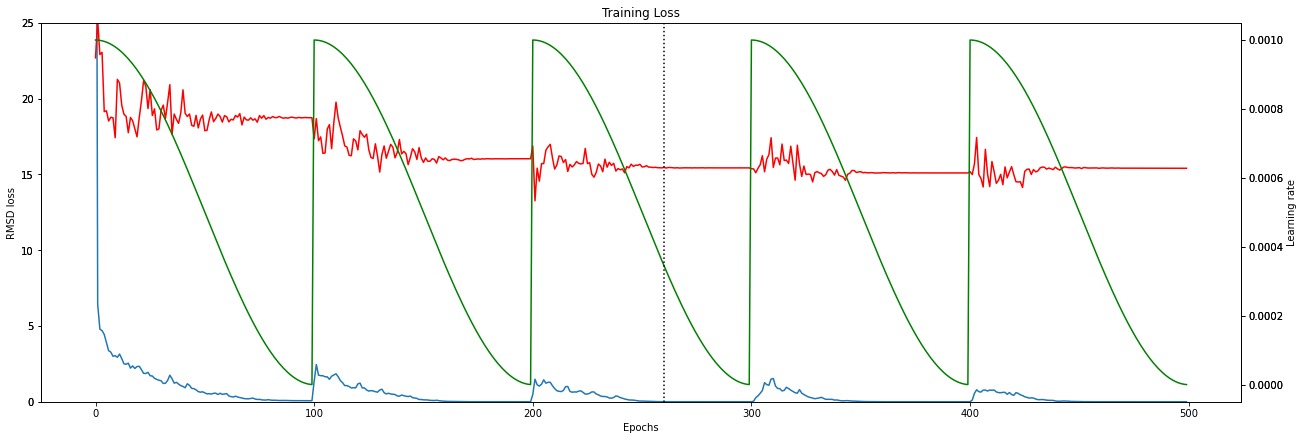

In [16]:
#plot the training run
fig, ax1 = plt.subplots(layout='constrained', figsize=(18, 6))
ax1.secondary_yaxis('left')
ax1.plot(epoch_losses)
ax1.plot(val_losses, 'r')
ax2 = ax1.twinx()
ax2.secondary_yaxis('right')
ax2.plot(learning_rates, 'g')
plt.title("Training Loss")
ax1.set_xlabel("Epochs")
ax1.set_ylabel("RMSD loss")
ax2.set_ylabel("Learning rate")
ax1.set_ybound(lower=0, upper=25)
plt.axvline(x = 260, c = 'black', ls = ':')
#plt.axvline(x = 96, c = 'black', ls = ':')
#plt.axvline(x = 145, c = 'black', ls = ':')
#plt.axvline(x = 190, c = 'black', ls = ':')
#plt.axvline(x = 250, c = 'black', ls = ':')
#plt.axvline(x = 321, c = 'black', ls = ':')
#plt.axvline(x = 404, c = 'black', ls = ':')
plt.draw()

In [12]:
#Test Data
test_dir = "./data/test_set"
test_rmsd = "./data/test_rmsd_list.txt"

test_dataset = CGDataset(test_dir, test_rmsd, device)

test_dataloader = dtl.pytorch.GraphDataLoader(test_dataset)

In [13]:
#5S rRNA and tRNA Test Data (previous training data)
st_test_dir = "./data/old_training_set"
st_test_rmsd = "./data/old_train_rmsd_list.txt"

st_test_dataset = CGDataset(st_test_dir, st_test_rmsd, device)

st_test_dataloader = dtl.pytorch.GraphDataLoader(st_test_dataset)

Normal Test Set
tensor([25.5980], device='cuda:0') tensor([25.6268], device='cuda:0', grad_fn=<AddBackward0>) 0.028768539428710938
tensor([0.], device='cuda:0') tensor([94.3275], device='cuda:0', grad_fn=<AddBackward0>) 94.32748413085938
Mean Test loss: 	 20.3726
Std. Dev. of Test loss:  22.7868
Min loss: 		 0.0288
First Quantile: 	 5.1067
Median: 		 12.2510
Third Quantile: 	 23.4088
Max Loss: 		 94.3275


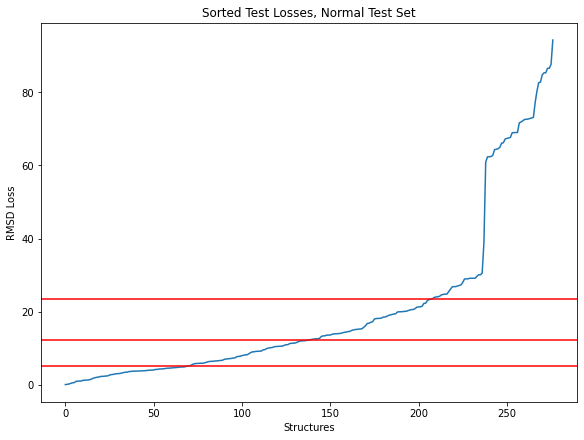

tensor([0.7070], device='cuda:0') tensor([-0.2740], device='cuda:0', grad_fn=<AddBackward0>)
tensor([0.7110], device='cuda:0') tensor([-0.6114], device='cuda:0', grad_fn=<AddBackward0>)
tensor([0.3440], device='cuda:0') tensor([-0.0579], device='cuda:0', grad_fn=<AddBackward0>)
tensor([0.4350], device='cuda:0') tensor([-0.1075], device='cuda:0', grad_fn=<AddBackward0>)
tensor([0.], device='cuda:0') tensor([-0.0060], device='cuda:0', grad_fn=<AddBackward0>)
tensor([2.1090], device='cuda:0') tensor([-0.0052], device='cuda:0', grad_fn=<AddBackward0>)
5S rRNA and tRNA Test Set
tensor([0.], device='cuda:0') tensor([-0.0060], device='cuda:0', grad_fn=<AddBackward0>) 0.00601887796074152
tensor([0.], device='cuda:0') tensor([98.4464], device='cuda:0', grad_fn=<AddBackward0>) 98.44635772705078
Mean Test loss: 	 7.9330
Std. Dev. of Test loss:  16.1049
Min loss: 		 0.0060
First Quantile: 	 1.2092
Median: 		 2.7416
Third Quantile: 	 5.6130
Max Loss: 		 98.4464


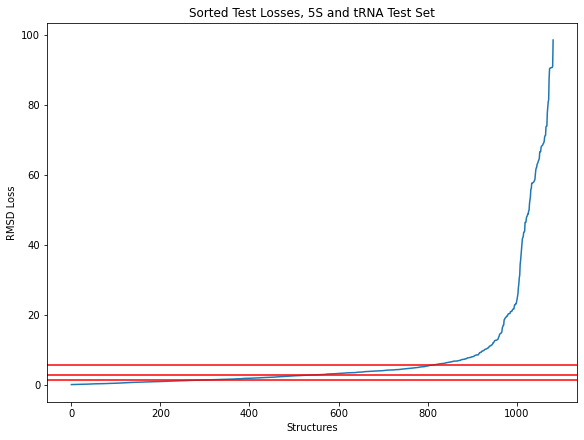

In [17]:
#Test
import math

if "model" not in globals():
    model = CG_Classifier(num_features=3)

model.to(device)

model.load_state_dict(th.load("dgl_model_data/model_epoch260.pth"))

model.eval()

for loader in [test_dataloader, st_test_dataloader]:
    max_label = 0
    max_loss = 0
    max_pred = 0
    min_label = math.inf
    min_loss = math.inf
    min_pred = math.inf
    test_losses = []
    for test_graph, test_label in loader:
        test_pred = model(test_graph)
        test_loss = F.l1_loss(test_pred, test_label).item() #smooth_l1_loss
        test_losses.append(test_loss)
        if test_loss > max_loss:
            max_loss = test_loss
            max_label = test_label
            max_pred = test_pred
        if test_loss < min_loss:
            min_loss = test_loss
            min_label = test_label
            min_pred = test_pred
        if test_pred < 0:
            print(test_label, test_pred)

    if loader == test_dataloader:
        print("Normal Test Set")
    elif loader == st_test_dataloader:
        print("5S rRNA and tRNA Test Set")
    print(min_label, min_pred, min_loss)
    print(max_label, max_pred, max_loss)
    test_mean = np.mean(test_losses)
    test_std = np.std(test_losses)
    test_fq = np.quantile(test_losses, q = 0.25)
    test_median = np.median(test_losses)
    test_tq = np.quantile(test_losses, q = 0.75)
    print("Mean Test loss: \t {:.4f}".format(test_mean))
    print("Std. Dev. of Test loss:  {:.4f}".format(test_std))
    print("Min loss: \t\t {:.4f}".format(min(test_losses)))
    print("First Quantile: \t {:.4f}".format(test_fq))
    print("Median: \t\t {:.4f}".format(test_median))
    print("Third Quantile: \t {:.4f}".format(test_tq))
    print("Max Loss: \t\t {:.4f}".format(max(test_losses)))

    #print(sorted(test_losses)[-5:])

    fig, axs = plt.subplots(layout='constrained', figsize=(8, 6))
    axs.plot(sorted(test_losses))
    #plt.title("Sorted Test Losses")
    if loader == test_dataloader:
        plt.title("Sorted Test Losses, Normal Test Set")
    elif loader == st_test_dataloader:
        plt.title("Sorted Test Losses, 5S and tRNA Test Set")
    plt.ylabel("RMSD Loss")
    plt.xlabel("Structures")
    plt.axhline(y = test_fq, color = 'r')
    plt.axhline(y = test_median, color = 'r')
    plt.axhline(y = test_tq, color = 'r')
    plt.show()

In [ ]:
#play ground for diffpool
#adapted from: https://github.com/dmlc/dgl/blob/master/examples/pytorch/diffpool/model/dgl_layers/gnn.py
import numpy as np
import dgl.nn as dglnn
import torch.nn.functional as F

test_g = training_dataset[0][0]

#Diffpool returns a new adjacency matrix
# --> difficult/cant be used with the graph structure in dgl
# --> use pytorch geometric instead of dgl (or in addition?) when trying out diffpool?

def diffpool(g, feat):
    feat_gc = dglnn.SAGEConv(6, 10, 'pool')
    pool_gc = dglnn.SAGEConv(10, 6, 'pool')

    feat = feat_gc(g, feat)
    device = feat.device

    assign_tensor = pool_gc(g, feat)  # size = (sum_N, N_a), N_a is num of nodes in pooled graph.
    assign_tensor = F.softmax(assign_tensor, dim=1)
    assign_tensor = th.split(assign_tensor, g.batch_num_nodes().tolist())
    assign_tensor = th.block_diag(*assign_tensor)  # size = (sum_N, batch_size * N_a)

    h = th.matmul(th.t(assign_tensor), feat)
    adj = g.adjacency_matrix(transpose=True, ctx=device)
    adj_new = th.sparse.mm(adj, assign_tensor)
    adj_new = th.mm(th.t(assign_tensor), adj_new)

    print("Graph\n", g)
    print("Coords\n",g.ndata["coord"])
    print("Adjacency\n",adj)
    print("Adjacency new\n",adj_new)
    print("feature\n",h)
    return adj_new, h


feat = test_g.ndata["coord"]

new, h = diffpool(test_g, feat)
#new, h = diffpool(new, h)

s2s = dglnn.Set2Set(6, 3, 3)
print("Set2Set")
print(s2s(test_g, feat))